In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
from libdeeppatcher.arachne import Arachne
from libdeeppatcher import utils
from libdeeppatcher.types import Dataset
from libdeeppatcher import prepare
from libdeeppatcher import report
from libdeeppatcher import metrics
from IPython.display import clear_output
from keras import backend as K

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, precision_recall_curve
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA

import lightgbm as lgb

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.size'] = 5
sns.set_context('paper', font_scale=2)

import shap

# Load the repairs data of each dataset and model

In [10]:
model_and_dataset = [
    ('mnist_dense', 'mnist_flat'),
    ('mnist_dense5', 'mnist_flat'),
    ('mnist_convolutional', 'mnist_conv'),
    ('mnist_conv4', 'mnist_conv'),
    ('fmnist_dense', 'fmnist_flat'),
    ('fmnist_dense5', 'fmnist_flat'),
    ('fmnist_convolutional', 'fmnist_conv'),
    ('fmnist_conv4', 'fmnist_conv'),
]

In [11]:
df_list = []
for model_name, dataset_name in model_and_dataset:
    print(model_name, dataset_name)
    tmp = pd.read_csv('./side_effect_dataset/'+model_name+'.csv', index_col=0)
    print(tmp.shape)
    df_list.append(tmp)

mnist_dense mnist_flat
(5759, 10)
mnist_dense5 mnist_flat
(5734, 10)
mnist_convolutional mnist_conv
(5878, 10)
mnist_conv4 mnist_conv
(5863, 10)
fmnist_dense fmnist_flat
(5286, 10)
fmnist_dense5 fmnist_flat
(5244, 10)
fmnist_convolutional fmnist_conv
(5500, 10)
fmnist_conv4 fmnist_conv
(5470, 10)


# Concat dataframes and Make objective variable
The history of repair for each dataset is combined into a single dataframe.
If a prediction is broken at least once out of the five repairs, it is considered broken data (the objective variable is True).

In [12]:
df = pd.concat(df_list, ignore_index=True)
sum_broken = df[[f'broken_{i}' for i in range(1,6)]].sum(axis=1)
df['result'] = (sum_broken > 0)
df.drop([f'broken_{i}' for i in range(1,6)], axis=1, inplace=True)
display(df)
display(df['result'].value_counts())

,pcs,entropy,label_pred_score,loss,result
0,0.985625,8.955458e-02,0.990823,9.218977e-03,False
1,0.997302,1.879194e-02,0.998458,1.543341e-03,False
2,0.952544,1.988826e-01,0.974007,2.633696e-02,False
3,0.997227,2.138374e-02,0.998169,1.832852e-03,False
4,0.990204,6.512174e-02,0.993671,6.349173e-03,False
...,...,...,...,...,...
44729,1.000000,4.480177e-06,1.000000,1.192093e-07,False
44730,0.950967,1.675730e-01,0.975432,2.487528e-02,False
44731,1.000000,6.485318e-09,1.000000,1.192093e-07,False
44732,0.978265,1.407077e-01,0.984954,1.515967e-02,False


False    39755
True      4979
Name: result, dtype: int64

# Hold test data

In [13]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=777)
X_test, y_test = df_test.drop('result', axis=1), df_test['result']

In [14]:
train_pos_ratio = df_train['result'].sum() / df_train['result'].shape[0]
test_pos_ratio = df_test['result'].sum() / df_test['result'].shape[0]
print(f'train_pos_ratio = {train_pos_ratio} ({df_train["result"].sum()}/{df_train["result"].shape[0]})')
print(f'test_pos_ratio = {test_pos_ratio} ({df_test["result"].sum()}/{df_test["result"].shape[0]})')

train_pos_ratio = 0.11168860200631514 (3997/35787)
test_pos_ratio = 0.10975746060131888 (982/8947)


# Check the distribution of each column of training data

In [54]:
df_train.describe()

,pcs,entropy,label_pred_score,loss
count,35787.000000,3.578700e+04,35787.000000,3.578700e+04
mean,0.924254,1.883685e-01,0.956734,5.237088e-02
std,0.182603,3.712461e-01,0.104618,1.384524e-01
min,0.000020,1.559610e-11,0.231782,1.192093e-07
25%,0.966647,6.392736e-04,0.980508,3.695556e-05
50%,0.998216,1.350916e-02,0.998926,1.074593e-03
75%,0.999939,1.581797e-01,0.999963,1.968408e-02
max,1.000000,2.732958e+00,1.000000,1.461958e+00


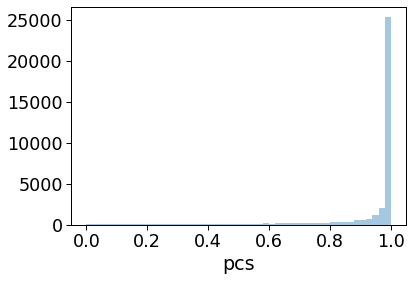

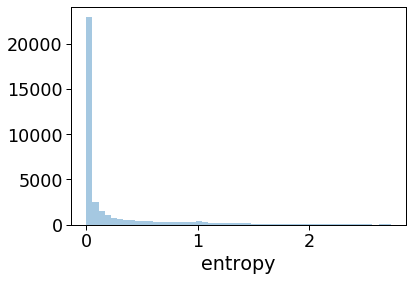

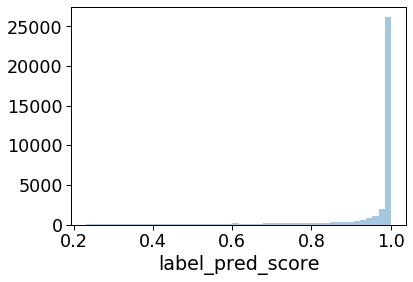

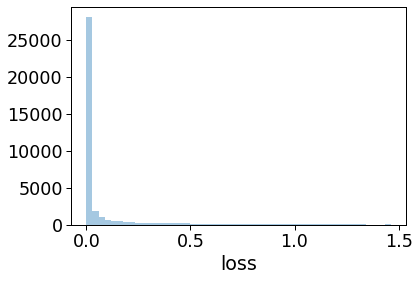

In [55]:
for col in df_train.columns:
    if col == 'result':
        continue
    sns.distplot(df_train[col], kde=False)
    plt.show()

# Balance labels on training data

In [56]:
df_train['result'].value_counts()

False    31790
True      3997
Name: result, dtype: int64

In [57]:
def under_sampling(data: pd.DataFrame):
    low_frequency_data_sample = data[data['result'] == True]
    low_frequency_data_size = len(low_frequency_data_sample)
    
    high_frequency_data_indeces = data[data['result'] == False].index

    np.random.seed(seed=7)
    random_indices = np.random.choice(high_frequency_data_indeces, low_frequency_data_size, replace=False)
    high_frequency_data_sample = data.loc[random_indices]
    
    merged_data = pd.concat([high_frequency_data_sample, low_frequency_data_sample], ignore_index=True)
    balanced_data = pd.DataFrame(merged_data)
    return balanced_data

In [58]:
df_uns = under_sampling(df_train)
display(df_uns['result'].value_counts())

True     3997
False    3997
Name: result, dtype: int64

# Box-Cox transformation
Distributions of these metrics are very long-taled so we perform Box-Cox transformation.

In [59]:
def boxcox(x, l):
    if l is None:
        return x
    elif l == 0:
        return np.log1p(x)
    else:
        return (x**l - 1) / l

## Search parameter for Box-Cox

In [60]:
from collections import defaultdict
boxcox_ls = defaultdict(float)

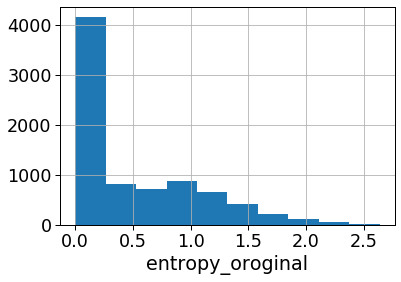

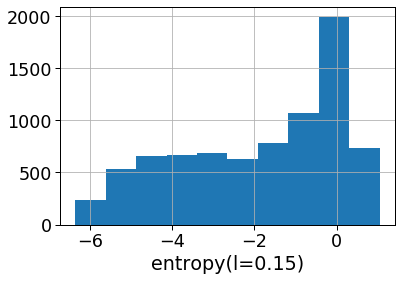

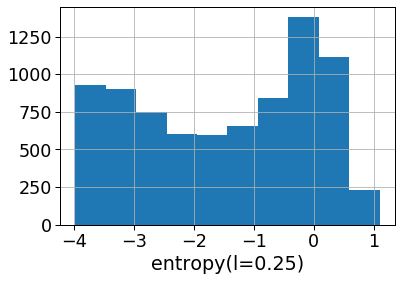

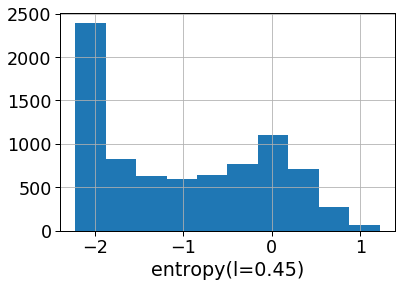

In [61]:
l_candidates = [0.15, 0.25, 0.45]
col = 'entropy'
plt.xlabel(f'{col}_oroginal')
df_uns[col].hist()
plt.show()
for l in l_candidates:
    boxcox(df_uns[col], l).hist()
    plt.xlabel(f'{col}(l={l})')
    plt.show()

In [62]:
boxcox_ls['entropy'] = 0.3

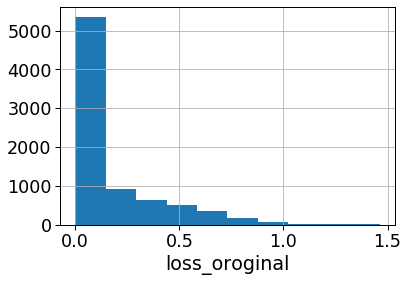

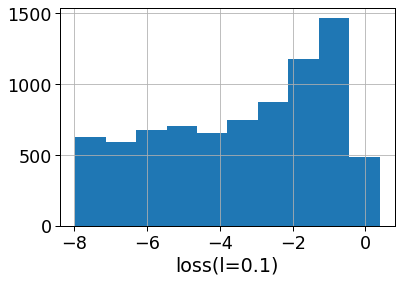

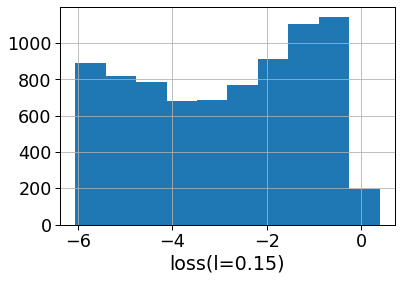

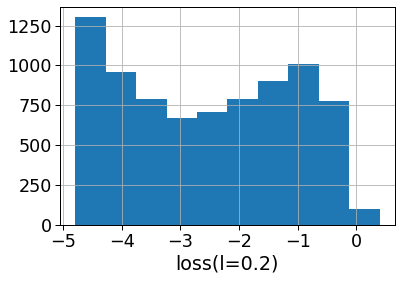

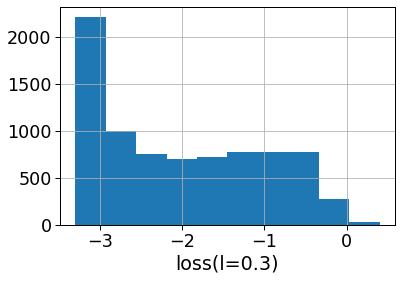

In [63]:
l_candidates = [0.1, 0.15, 0.2, 0.3]
col = 'loss'
plt.xlabel(f'{col}_oroginal')
df_uns[col].hist()
plt.show()
for l in l_candidates:
    boxcox(df_uns[col], l).hist()
    plt.xlabel(f'{col}(l={l})')
    plt.show()

In [64]:
boxcox_ls['loss'] = 0.3

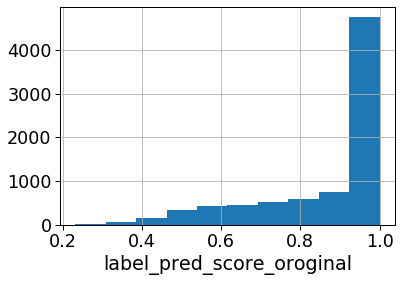

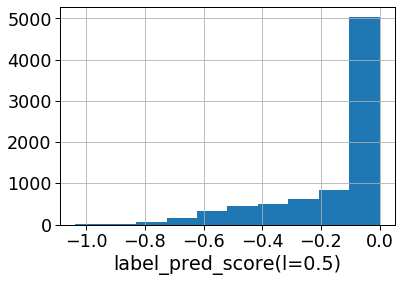

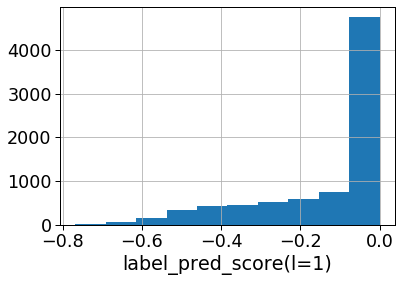

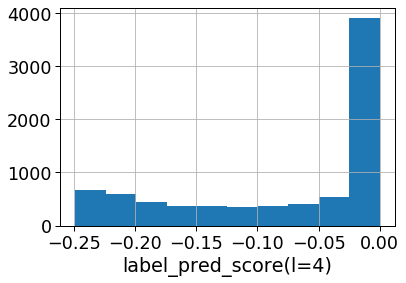

In [65]:
l_candidates = [0.5, 1, 4]
col = 'label_pred_score'
plt.xlabel(f'{col}_oroginal')
df_uns[col].hist()
plt.show()
for l in l_candidates:
    boxcox(df_uns[col], l).hist()
    plt.xlabel(f'{col}(l={l})')
    plt.show()

In [66]:
boxcox_ls['label_pred_score'] = None

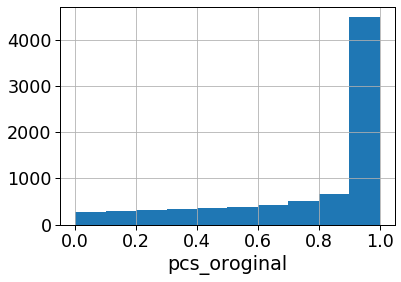

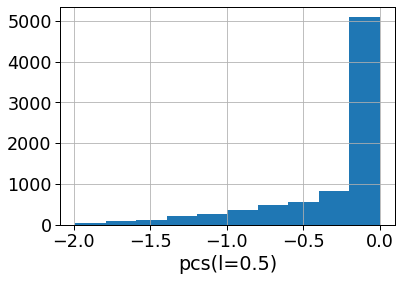

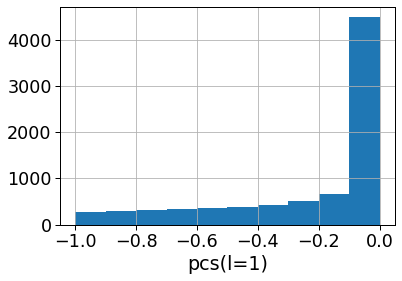

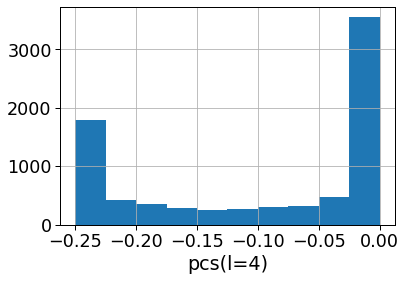

In [67]:
l_candidates = [0.5, 1, 4]
col = 'pcs'
plt.xlabel(f'{col}_oroginal')
df_uns[col].hist()
plt.show()
for l in l_candidates:
    boxcox(df_uns[col], l).hist()
    plt.xlabel(f'{col}(l={l})')
    plt.show()

In [68]:
boxcox_ls['pcs'] = None

In [69]:
boxcox_ls

defaultdict(float,
            {'entropy': 0.3,
             'loss': 0.3,
             'label_pred_score': None,
             'pcs': None})

## Perform Box-Cox transformation
The parameters obtained above are used to perform the box-cox transformation.

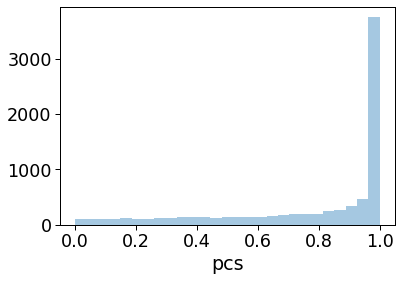

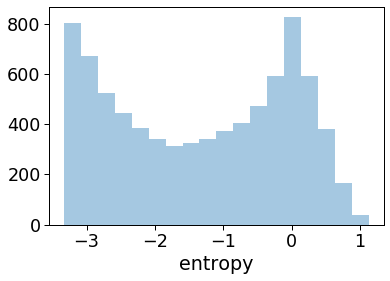

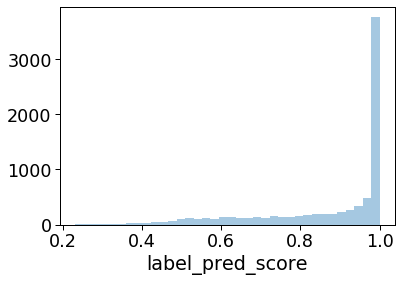

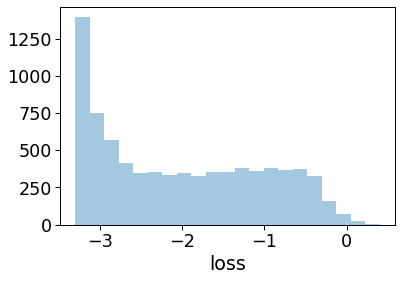

In [70]:
df_train_boxcox = df_uns.copy()
for col in df_uns.columns:
    if col == 'result':
        continue
#     df_train[col] = df_train[col].apply(np.log1p)
    df_train_boxcox[col] = boxcox(df_uns[col], boxcox_ls[col])
for col in df_uns.columns:
    if col == 'result':
        continue
    sns.distplot(df_train_boxcox[col], kde=False)
    plt.show()

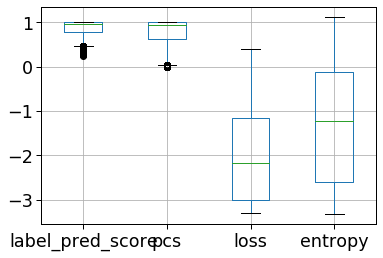

In [71]:
df_train_boxcox.boxplot(column=['label_pred_score', 'pcs', 'loss', 'entropy'])

# Standardize each column in the training data

In [73]:
df_train_boxcox

,pcs,entropy,label_pred_score,loss,result
0,0.999243,-2.566518,0.999469,-2.986170,False
1,0.995744,-2.216934,0.997663,-2.791772,False
2,0.990372,-1.813943,0.992980,-2.579558,False
3,0.999121,-2.529196,0.999383,-2.970236,False
4,1.000000,-3.271438,1.000000,-3.305423,False
...,...,...,...,...,...
7989,0.552079,0.278125,0.727549,-0.969390,True
7990,0.209769,-0.027630,0.604709,-0.620948,True
7991,0.366354,0.790704,0.537671,-0.444629,True
7992,0.943011,-1.197470,0.968948,-2.151500,True


In [74]:
df_train_boxcox_filtered_std = df_train_boxcox.copy()
scaled_columns = [feat for feat in list(df_train_boxcox_filtered.columns) if feat != 'result']
std = StandardScaler()
sc_train = std.fit(df_train_boxcox[scaled_columns])
std_cols = sc_train.transform(df_train_boxcox[scaled_columns])
df_train_boxcox_filtered_std[scaled_columns] = std_cols

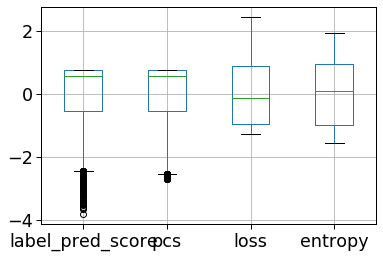

In [75]:
df_train_boxcox_filtered_std.boxplot(column=['label_pred_score', 'pcs', 'loss', 'entropy'])

# Examine the relationship of each metric to the objective variable

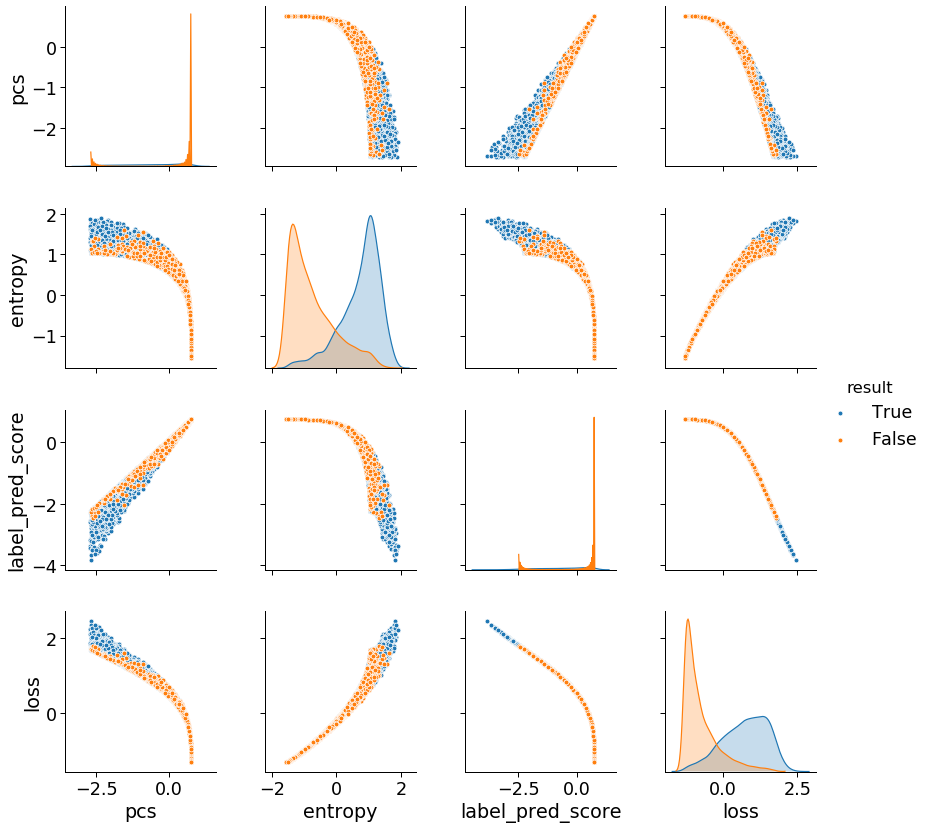

In [76]:
sns.pairplot(df_train_boxcox_filtered_std,
             vars=[
                 'pcs',
                 'entropy',
                 'label_pred_score',
                 'loss'
             ],
             height=3,
             hue='result',
             hue_order=[True, False]
            )
plt.show()

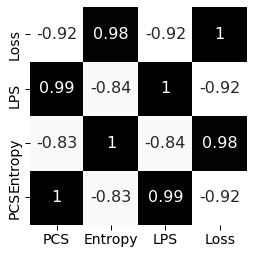

In [77]:
tmp_df = df_train_boxcox_filtered_std.copy()
tmp_df.columns = ['PCS', 'Entropy', 'LPS', 'Loss', 'result']
# 相関係数のヒートマップ
sns.heatmap(
    tmp_df.drop(['result'], axis=1).corr(),
    square=True, cbar=False, annot=True, cmap='Greys',annot_kws={"size":16}
)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0, 4)
plt.savefig('./side-effect_corr.pdf', format='pdf', dpi=300, bbox_inches='tight')

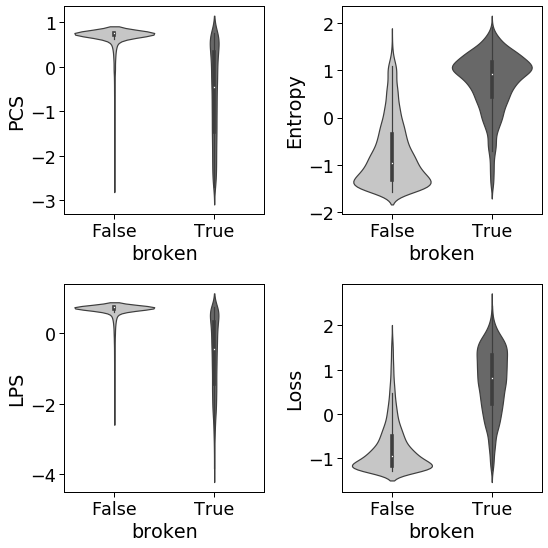

In [78]:
tmp_df = df_train_boxcox_filtered_std.copy()
tmp_df.columns = ['PCS', 'Entropy', 'LPS', 'Loss', 'broken']
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=False, figsize=(8, 8))
plt.subplots_adjust(wspace=0.2, hspace=0.4)
feats = [feat for feat in list(tmp_df.columns) if feat != 'broken']
for ax, feat in zip(axes.flatten(), feats):
    sns.violinplot(data=tmp_df, x='broken', y=feat, palette='Greys', ax=ax)
#     ax.xaxis.label.set_size(16)
#     ax.yaxis.label.set_size(16)
#     plt.xticks(fontsize=16)
#     plt.yticks(fontsize=16)
fig.tight_layout()
fig.show()
fig.savefig("./side-effect_violin.pdf", format='pdf', dpi=300, bbox_inches='tight')

# Build a logistic regression model
We perform 5-fold cross-validation.

In [79]:
display(df_train_boxcox_filtered_std)
X_train, y_train = df_train_boxcox_filtered_std.drop(['result'], axis=1), df_train_boxcox_filtered_std['result']
print(X_train.shape)
print(y_train.shape)

,pcs,entropy,label_pred_score,loss,result
0,0.753135,-0.971653,0.743045,-0.960857,False
1,0.741042,-0.698908,0.732274,-0.765557,False
2,0.722469,-0.384495,0.704345,-0.552358,False
3,0.752714,-0.942535,0.742532,-0.944849,False
4,0.755752,-1.521632,0.746213,-1.281590,False
...,...,...,...,...,...
7989,-0.792658,1.247737,-0.878676,1.065280,True
7990,-1.975985,1.009187,-1.611291,1.415338,True
7991,-1.434687,1.647651,-2.011103,1.592476,True
7992,0.558747,0.096478,0.561018,-0.122314,True


(7994, 4)
(7994,)


In [80]:
kf = KFold(n_splits=5, shuffle=True, random_state=1234)
parameters = {'C': [10**i for i in range(-2, 4)], 'random_state': [1234]}
clf_log = LogisticRegression()
grid_log = GridSearchCV(clf_log, param_grid=parameters, cv=kf, scoring='accuracy', verbose=2)
grid_log.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] C=0.01, random_state=1234 .......................................
[CV] ........................ C=0.01, random_state=1234, total=   0.0s
[CV] C=0.01, random_state=1234 .......................................
[CV] ........................ C=0.01, random_state=1234, total=   0.0s
[CV] C=0.01, random_state=1234 .......................................
[CV] ........................ C=0.01, random_state=1234, total=   0.0s
[CV] C=0.01, random_state=1234 .......................................
[CV] ........................ C=0.01, random_state=1234, total=   0.0s
[CV] C=0.01, random_state=1234 .......................................
[CV] ........................ C=0.01, random_state=1234, total=   0.0s
[CV] C=0.1, random_state=1234 ........................................
[CV] ......................... C=0.1, random_state=1234, total=   0.0s
[CV] C=0.1, random_state=1234 ........................................
[CV] ............

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.


[CV] ......................... C=0.1, random_state=1234, total=   0.0s
[CV] C=0.1, random_state=1234 ........................................
[CV] ......................... C=0.1, random_state=1234, total=   0.0s
[CV] C=0.1, random_state=1234 ........................................
[CV] ......................... C=0.1, random_state=1234, total=   0.0s
[CV] C=1, random_state=1234 ..........................................
[CV] ........................... C=1, random_state=1234, total=   0.0s
[CV] C=1, random_state=1234 ..........................................
[CV] ........................... C=1, random_state=1234, total=   0.0s
[CV] C=1, random_state=1234 ..........................................
[CV] ........................... C=1, random_state=1234, total=   0.0s
[CV] C=1, random_state=1234 ..........................................
[CV] ........................... C=1, random_state=1234, total=   0.0s
[CV] C=1, random_state=1234 ..........................................
[CV] .

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to


[CV] C=10, random_state=1234 .........................................
[CV] .......................... C=10, random_state=1234, total=   0.0s
[CV] C=100, random_state=1234 ........................................
[CV] ......................... C=100, random_state=1234, total=   0.0s
[CV] C=100, random_state=1234 ........................................
[CV] ......................... C=100, random_state=1234, total=   0.0s
[CV] C=100, random_state=1234 ........................................
[CV] ......................... C=100, random_state=1234, total=   0.0s
[CV] C=100, random_state=1234 ........................................
[CV] ......................... C=100, random_state=1234, total=   0.0s
[CV] C=100, random_state=1234 ........................................
[CV] ......................... C=100, random_state=1234, total=   0.0s
[CV] C=1000, random_state=1234 .......................................
[CV] ........................ C=1000, random_state=1234, total=   0.0s
[CV] 

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.


[CV] ........................ C=1000, random_state=1234, total=   0.0s
[CV] C=1000, random_state=1234 .......................................
[CV] ........................ C=1000, random_state=1234, total=   0.0s


Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.6s finished
Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.


GridSearchCV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000],
                         'random_state': [1234]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=2)

In [82]:
def preprocess_test(X_test, sc_train, boxcox_ls):
    X_test_std = X_test.copy()
    X_test_std['loss'] = boxcox(X_test_std['loss'], boxcox_ls['loss'])
    X_test_std['entropy'] = boxcox(X_test_std['entropy'], boxcox_ls['entropy'])
    X_test_std['label_pred_score'] = boxcox(X_test_std['label_pred_score'], boxcox_ls['label_pred_score'])
    X_test_std['pcs'] = boxcox(X_test_std['pcs'], boxcox_ls['pcs'])
    std_cols = sc_train.transform(X_test_std)
    X_test_std = std_cols
    return X_test_std
    

def print_perf(clf, X, y):
    y_pred = clf.predict(X)
    acc = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    print(f'Accuracy: {acc:.3}')
    print(f'Precision: {precision:.3}')
    print(f'Recall: {recall:.3}')
    print(f'F1: {f1:.3}\n')
    
def plot_conf_mat(clf, X, y):
    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Reds', fmt='d')
    plt.ylim(0, cm.shape[0])
    plt.ylabel('true')
    plt.xlabel('pred')
    plt.show()

Accuracy: 0.869
Precision: 0.863
Recall: 0.877
F1: 0.87



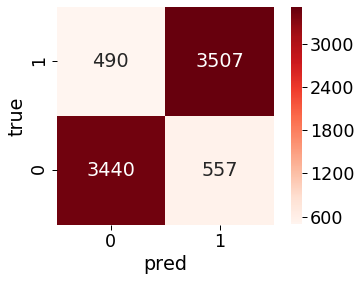

Accuracy: 0.861
Precision: 0.434
Recall: 0.871
F1: 0.579



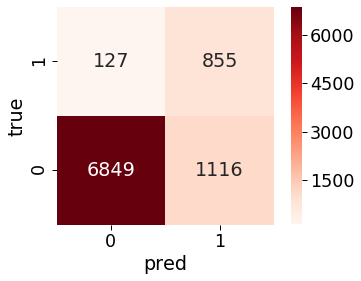

In [83]:
# the performance for training data
print_perf(grid_log, X_train, y_train)
plot_conf_mat(grid_log, X_train, y_train)
# the performance for test data
X_test_std = preprocess_test(X_test, sc_train, boxcox_ls)
print_perf(grid_log, X_test_std, y_test)
plot_conf_mat(grid_log, X_test_std, y_test)

# Build a LightGBM model
We perform 5-fold cross-validation.

In [84]:
kf = KFold(n_splits=5, shuffle=True, random_state=1234)
parameters = {'max_depth': [10, 25, 50, 75],
              'learning_rate': [0.001, 0.01, 0.05, 0.1],
              'n_estimators': [10, 50, 100, 200, 500]
}
clf_lgb = lgb.LGBMClassifier(random_state=1234)
grid_lgb = GridSearchCV(clf_lgb, param_grid=parameters, cv=kf, scoring='accuracy', verbose=2)
grid_lgb.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV] learning_rate=0.001, max_depth=10, n_estimators=10 ..............
[CV]  learning_rate=0.001, max_depth=10, n_estimators=10, total=   0.1s
[CV] learning_rate=0.001, max_depth=10, n_estimators=10 ..............
[CV]  learning_rate=0.001, max_depth=10, n_estimators=10, total=   0.1s
[CV] learning_rate=0.001, max_depth=10, n_estimators=10 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  learning_rate=0.001, max_depth=10, n_estimators=10, total=   0.1s
[CV] learning_rate=0.001, max_depth=10, n_estimators=10 ..............
[CV]  learning_rate=0.001, max_depth=10, n_estimators=10, total=   0.0s
[CV] learning_rate=0.001, max_depth=10, n_estimators=10 ..............
[CV]  learning_rate=0.001, max_depth=10, n_estimators=10, total=   0.1s
[CV] learning_rate=0.001, max_depth=10, n_estimators=50 ..............
[CV]  learning_rate=0.001, max_depth=10, n_estimators=50, total=   0.1s
[CV] learning_rate=0.001, max_depth=10, n_estimators=50 ..............
[CV]  learning_rate=0.001, max_depth=10, n_estimators=50, total=   0.1s
[CV] learning_rate=0.001, max_depth=10, n_estimators=50 ..............
[CV]  learning_rate=0.001, max_depth=10, n_estimators=50, total=   0.1s
[CV] learning_rate=0.001, max_depth=10, n_estimators=50 ..............
[CV]  learning_rate=0.001, max_depth=10, n_estimators=50, total=   0.1s
[CV] learning_rate=0.001, max_depth=10, n_estimators=50 ..............

[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  1.1min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
             error_score='raise-deprecating',
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=1234, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='warn', n_jobs=None,
             param_gri

Accuracy: 0.876
Precision: 0.866
Recall: 0.888
F1: 0.877



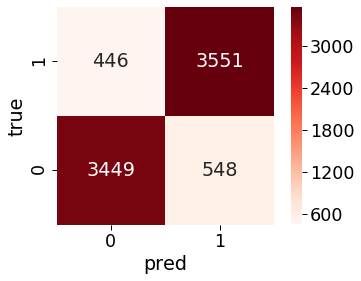

Accuracy: 0.852
Precision: 0.417
Recall: 0.869
F1: 0.563



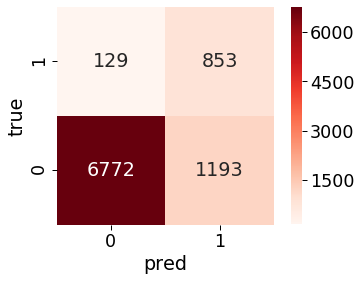

In [85]:
# the performance for training data
print_perf(grid_lgb, X_train, y_train)
plot_conf_mat(grid_lgb, X_train, y_train)
# the performance for test data
X_test_std = preprocess_test(X_test, sc_train, boxcox_ls)
print_perf(grid_lgb, X_test_std, y_test)
plot_conf_mat(grid_lgb, X_test_std, y_test)

# Build a random forest model
We perform 5-fold cross-validation.

In [86]:
kf = KFold(n_splits=5, shuffle=True, random_state=1234)
parameters = {'n_estimators': [50, 60, 70, 80, 90, 100], 'max_depth': [5, 10, 50]}
clf_rf = RandomForestClassifier(criterion='entropy', random_state=1234)
grid_rf = GridSearchCV(clf_rf, param_grid=parameters, cv=kf, scoring='accuracy', verbose=2)
grid_rf.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=5, n_estimators=50 ....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..................... max_depth=5, n_estimators=50, total=   0.5s
[CV] max_depth=5, n_estimators=50 ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] ..................... max_depth=5, n_estimators=50, total=   0.4s
[CV] max_depth=5, n_estimators=50 ....................................
[CV] ..................... max_depth=5, n_estimators=50, total=   0.4s
[CV] max_depth=5, n_estimators=50 ....................................
[CV] ..................... max_depth=5, n_estimators=50, total=   0.4s
[CV] max_depth=5, n_estimators=50 ....................................
[CV] ..................... max_depth=5, n_estimators=50, total=   0.4s
[CV] max_depth=5, n_estimators=60 ....................................
[CV] ..................... max_depth=5, n_estimators=60, total=   0.5s
[CV] max_depth=5, n_estimators=60 ....................................
[CV] ..................... max_depth=5, n_estimators=60, total=   0.5s
[CV] max_depth=5, n_estimators=60 ....................................
[CV] ..................... max_depth=5, n_estimators=60, total=   0.5s
[CV] max_depth=5, n_estimators=60 ....................................
[CV] .

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.8min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='entropy',
                                              max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              

Accuracy: 0.871
Precision: 0.854
Recall: 0.894
F1: 0.874



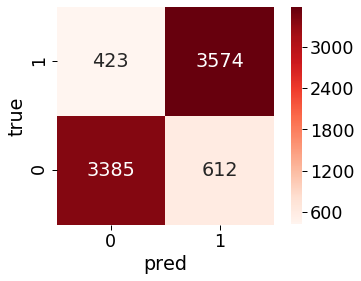

Accuracy: 0.846
Precision: 0.408
Recall: 0.884
F1: 0.558



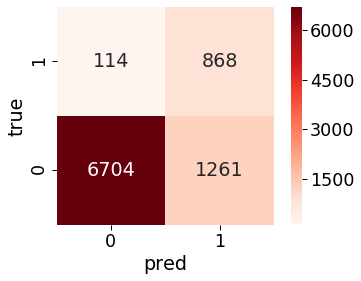

In [87]:
# the performance for training data
print_perf(grid_rf, X_train, y_train)
plot_conf_mat(grid_rf, X_train, y_train)
# the performance for test data
X_test_std = preprocess_test(X_test, sc_train, boxcox_ls)
print_perf(grid_rf, X_test_std, y_test)
plot_conf_mat(grid_rf, X_test_std, y_test)

# ROC / PR curves and calculate the AUC
The three models are compared in terms of ROC/PR curves and AUC.

In [88]:
res_log, res_lgb, res_rf = \
    grid_log.predict(X_test_std).astype(int), grid_lgb.predict(X_test_std).astype(int), grid_rf.predict(X_test_std).astype(int)
proba_log, proba_lgb, proba_rf = \
    grid_log.predict_proba(X_test_std), grid_lgb.predict_proba(X_test_std), grid_rf.predict_proba(X_test_std)

ROC

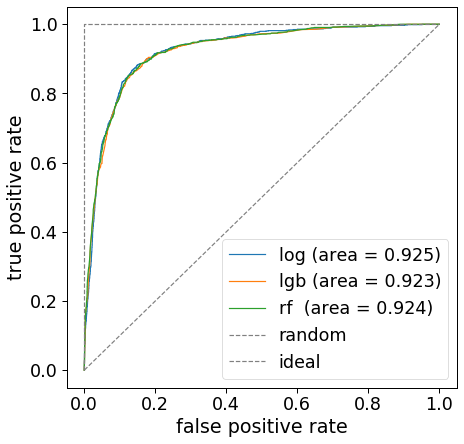

In [89]:
plt.subplots(figsize=(7,7))

fpr1, tpr1, thresholds = roc_curve(y_true=y_test, y_score=proba_log[:,1])
fpr2, tpr2, thresholds = roc_curve(y_true=y_test, y_score=proba_lgb[:,1])
fpr3, tpr3, thresholds = roc_curve(y_true=y_test, y_score=proba_rf[:,1])

plt.plot(fpr1, tpr1, label='log (area = %0.3f)' % auc(fpr1, tpr1))
plt.plot(fpr2, tpr2, label='lgb (area = %0.3f)' % auc(fpr2, tpr2))
plt.plot(fpr3, tpr3, label='rf  (area = %0.3f)' % auc(fpr3, tpr3))
plt.plot([0, 1], [0, 1], linestyle='--', label='random', c='gray')
plt.plot([0, 0, 1], [0, 1, 1], linestyle='--', label='ideal', c='gray')
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()


PR

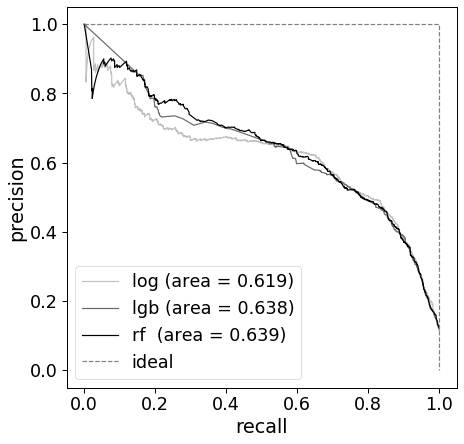

In [90]:
plt.subplots(figsize=(7,7))

pr1, re1, thresholds = precision_recall_curve(y_true=y_test, probas_pred=proba_log[:,1])
pr2, re2, thresholds = precision_recall_curve(y_true=y_test, probas_pred=proba_lgb[:,1])
pr3, re3, thresholds = precision_recall_curve(y_true=y_test, probas_pred=proba_rf[:,1])

plt.plot(re1, pr1, label='log (area = %0.3f)' % auc(re1, pr1), color='silver')
plt.plot(re2, pr2, label='lgb (area = %0.3f)' % auc(re2, pr2), color='dimgrey')
plt.plot(re3, pr3, label='rf  (area = %0.3f)' % auc(re3, pr3), color='black')
plt.plot([0, 1, 1], [1, 1, 0], linestyle='--', label='ideal', c='gray')
plt.legend()
plt.xlabel('recall')
plt.ylabel('precision')
plt.savefig("./pr_curve_side-eff.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()